
## Project: Creating Customer Segments

## Getting Started

In this project, various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure were analyzed. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). The features `'Channel'` and `'Region'` will be excluded and used for validation of results from K-means and Gaussian Mixture Model Clustering.


In [42]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")


Wholesale customers dataset has 440 samples with 6 features each.


In [41]:
try:
    data_test = pd.read_csv("customers.csv")
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 8 features each.


## Data Exploration

In [3]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [14]:
# Display a description of the dataset
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
data[data['Delicatessen'] == data['Delicatessen'].max()]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
183,36847,43950,20170,36534,239,47943


In [6]:
data[data['Milk'] == data['Milk'].max()]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,22925,73498,32114,987,20070,903


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. **Three** indices of your choice to the `indices` list which will represent the customers to track. 

In [7]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [86,182,400]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
samples

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,22925,73498,32114,987,20070,903
1,694,8533,10518,443,6907,156
2,4446,906,1238,3576,153,1014


Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. comparing the samples to the mean values below, some guesses to classify the customers are presented below: 

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 3071.9
* Detergents_paper: 2881.4
* Delicatessen: 1524.8




1. Given the really high volumes of Fresh, Milk, Greocery and Detergents_Paper this could be a `retailer`
2. Above average Milk and Grocery Detergents_Paper - this could be a `bakery`
3. Below avarage spend on all catogiries - This could be a `big household`, samll `eatery`


### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.



In [8]:
# correlation will show the linear relationships amoungst the categories in the data
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


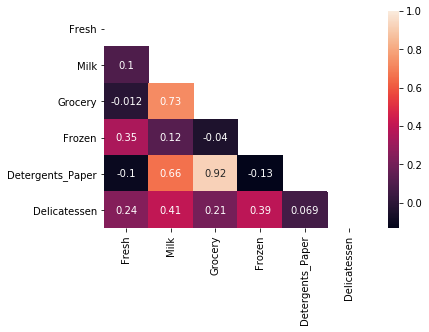

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask,annot=True)

In [10]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,explained_variance_score


for i in data.columns:
    # TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data.drop(i,axis=1)

    # TODO: Split the data into training and testing sets(0.25) using the given feature as the target
    # Set a random state.
    X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    data[i], 
                                                    test_size = 0.25, 
                                                    random_state = 0)
    
    for j in [DecisionTreeRegressor,LinearRegression]:
        # TODO: Create a decision tree regressor and fit it to the training set
        regressor = j()
        regressor.fit(X_train,y_train)
        y_pred = regressor.predict(X_test)

        # TODO: Report the score of the prediction using the testing set
        score = r2_score(y_pred,y_test)
        print("score to predict {} is {} ({})".format(i,score,j))

/Users/sm649f/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


score to predict Fresh is -0.8452056797421867 (<class 'sklearn.tree.tree.DecisionTreeRegressor'>)
score to predict Fresh is -2.6614941903036593 (<class 'sklearn.linear_model.base.LinearRegression'>)
score to predict Milk is -0.28613816111803936 (<class 'sklearn.tree.tree.DecisionTreeRegressor'>)
score to predict Milk is 0.3391975910079985 (<class 'sklearn.linear_model.base.LinearRegression'>)
score to predict Grocery is 0.7653647783668345 (<class 'sklearn.tree.tree.DecisionTreeRegressor'>)
score to predict Grocery is 0.8778487650274817 (<class 'sklearn.linear_model.base.LinearRegression'>)
score to predict Frozen is -1.587695146875161 (<class 'sklearn.tree.tree.DecisionTreeRegressor'>)
score to predict Frozen is -12.96404420297933 (<class 'sklearn.linear_model.base.LinearRegression'>)
score to predict Detergents_Paper is 0.2734217915867413 (<class 'sklearn.tree.tree.DecisionTreeRegressor'>)
score to predict Detergents_Paper is 0.8223705968497071 (<class 'sklearn.linear_model.base.Linea


* I attempted to predict ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']
* The highest prediction score was noticed for 'Grocery' and 'Detergents_Paper'. These varibles a re highly correlated as well making it eays to predict one using the other.
* Therfore Dropping 'Detergents_Paper' would'nt mean a loss of information because 'Grocery' carries that variability

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.

/Users/sm649f/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


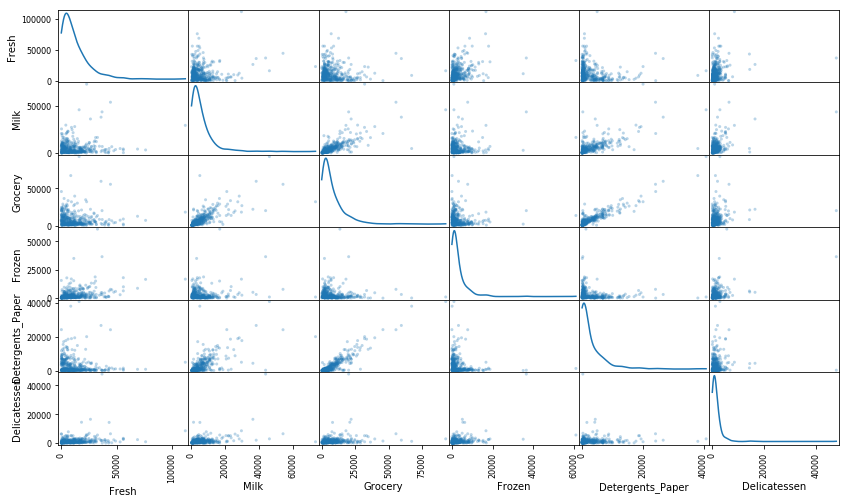

In [11]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


* The distributions present high skew and is thereofore far from normal distribution. Looks like the distribuitons replicate the chi squared distribution with 2 degrees of freedom.
* Like we observed above, 'Grocery' and 'Detergents_Paper' exhibit high correlation with each other. 'Grocery' and 'Detergents_Paper'also exhibit relatively high correlation wiht 'Milk'
* It conifrms the relevance between 'Grocery' and 'Detergents_Paper'.
* For thses features, most values reside between min and 25th percentile and very little values between 75th percentile and max. Because of the skewed distribution, it is best to rescale/ normalize scale.

## Data Preprocessing

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.


/Users/sm649f/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


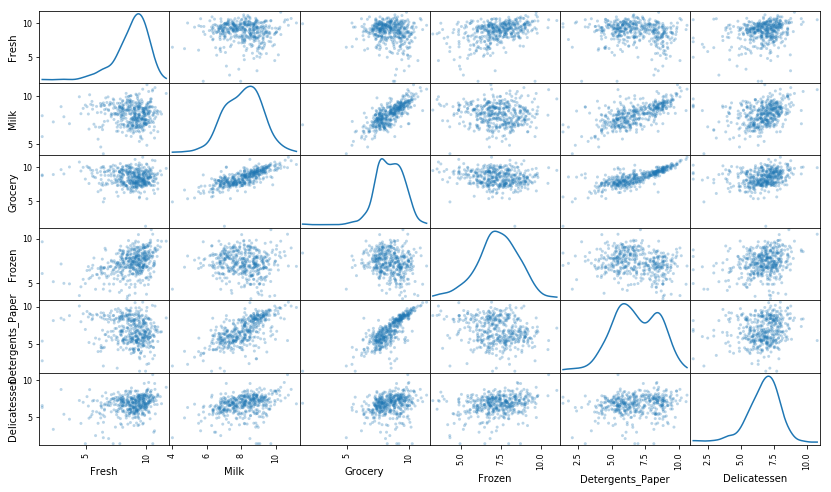

In [12]:
# TODO: Scale the data using the natural logarithm
log_data = data[['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper', 'Delicatessen']].apply(lambda x: np.log(x+1))

# TODO: Scale the sample data using the natural logarithm
log_samples = samples.apply(lambda x: np.log(x+1))

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. The correlation can be still seen as well

In [13]:
# Display the log-transformed sample data
log_samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.040027,11.205027,10.377078,6.895683,9.907031,6.806829
1,6.543912,9.051813,9.260938,6.095825,8.840435,5.056246
2,8.399985,6.810142,7.122060,8.182280,5.036953,6.922644


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.


In [15]:
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = []
freq_out = []
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25,axis=0)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75,axis=0)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    #outliers.append(list(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index))
    outliers = outliers + (list(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index))


print(outliers, len(outliers))
print("percentage of outliers {}".format(len(outliers)*100/log_data.shape[0]))

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205
81,5.393628,9.163354,9.575261,5.648974,8.964312,5.056246
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265
96,3.178054,7.869784,9.001962,4.983607,8.262301,5.384495
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294
171,5.303305,10.160569,9.894295,6.480045,9.079548,8.740497
193,5.198497,8.156510,9.918031,6.866933,8.633909,6.502790
218,2.944439,8.923325,9.629445,7.159292,8.475954,8.759826
304,5.087596,8.917445,10.117550,6.426488,9.374498,7.787797


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.040027,11.205027,10.377078,6.895683,9.907031,6.806829
98,6.222576,4.727388,6.658011,6.797940,4.043051,4.890349
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225
356,10.029547,4.905275,5.389072,8.057694,2.302585,6.308098


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.432071,9.663325,9.723763,3.526361,8.847504,6.073045
57,8.597482,9.203718,9.257987,3.663562,8.932345,7.156956
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225
145,10.000614,9.034200,10.457171,3.761200,9.440817,8.396381
175,7.759614,8.967759,9.382191,3.970292,8.342125,7.437206
264,6.979145,9.177817,9.645105,4.127134,8.696343,7.143618
325,10.395681,9.728241,9.519808,11.016496,7.149132,8.632306
420,8.402231,8.569216,9.490091,3.258097,8.827468,7.239933
429,9.060447,7.467942,8.183397,3.871201,4.442651,7.824846
439,7.933080,7.437795,7.828436,4.189655,6.169611,3.970292


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463
161,9.428270,6.293419,5.648974,6.996681,1.386294,7.711549


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294
137,8.035279,8.997271,9.021961,6.495266,6.582025,3.610918
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789
184,5.793014,6.823286,8.457655,4.317488,5.814131,2.484907
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294
203,6.369901,6.530878,7.703910,6.152733,6.861711,2.944439


[65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412, 86, 98, 154, 356, 75, 154, 38, 57, 65, 145, 175, 264, 325, 420, 429, 439, 75, 161, 66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343] 48
percentage of outliers 10.909090909090908


In [16]:
# occurrences of each outlier in a list
from collections import Counter
cnt = Counter()
for i in outliers:
    cnt[i] += 1

In [17]:
{k: v for k, v in cnt.items() if v>1}

{65: 2, 66: 2, 75: 2, 128: 2, 154: 3}

In [18]:
outlier_out = list({k for k, v in cnt.items() if v>1})

In [19]:
outlier_out

[128, 65, 66, 75, 154]

Removing the outliers across multiple features

In [20]:
# Remove the 3 outliers appeared across columns
good_data = log_data.drop(log_data.index[outlier_out]).reset_index(drop = True)

/Users/sm649f/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


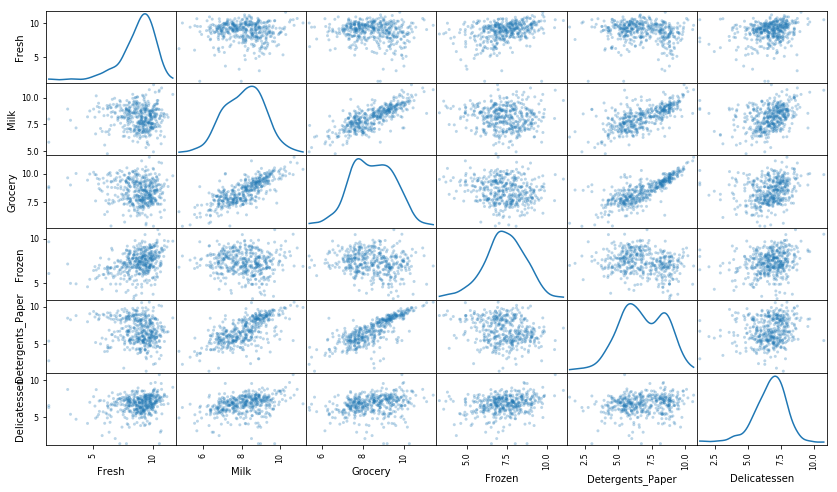

In [21]:
# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');



* Index no. [128, 65, 66, 75, 154] are the data points that fit the outlier definition for more than one feature
* These data points should be removed as they add multiple levels of varibility and may not be detected by processess like PCA give their presence amoung more than one frature
* 5 Data points were added ([128, 65, 66, 75, 154]) (little over 1% of data) to the outlier list and were removed form the data set.

## Feature Transformation

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.



In [22]:
log_samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.040027,11.205027,10.377078,6.895683,9.907031,6.806829
1,6.543912,9.051813,9.260938,6.095825,8.840435,5.056246
2,8.399985,6.810142,7.122060,8.182280,5.036953,6.922644


In [24]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 6)
pca.fit(good_data)

# Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)



In [25]:
pca.explained_variance_ 

array([ 4.52224884,  2.68339104,  1.23926309,  1.02454286,  0.49181146,
        0.209046  ])

In [26]:
pca.explained_variance_ratio_

array([ 0.44465231,  0.26384572,  0.12185114,  0.10073867,  0.0483576 ,
        0.02055455])

In [27]:
feature_weights = pd.DataFrame(pca.components_)
feature_weights.columns = good_data.columns

In [28]:
feature_weights.sum()

Fresh              -1.360546
Milk               -0.340814
Grocery             0.696126
Frozen              0.775350
Detergents_Paper   -1.523134
Delicatessen       -0.791874
dtype: float64


* The first prinicple componenet explains 44.4% of the varience where as second principle component explains 26.3% of the varience.
* The first four principle components explain 93.18% of the varience
* Detergents_Paper, Fresh, Delicatessen, Frozen explain the most varience in that order

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.


In [31]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

## Clustering




* KMeans advantages:
<br> Ease of implementation and high speed performance
<br> Measurable and efficient in large datasets
* Gaussian Mixture Models Advantages:
<br> GMM model accommodates mixed membership
<br> GMM is a lot more flexible in terms of cluster covariance
* Given the log transformed and outlier removed dataset approximates Normal distribution or Gaussian distribution, It is more appropriate to use Gaussian Mixture Model clustering algorithm

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [33]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
# TODO: Apply your clustering algorithm of choice to the reduced data
score = []
for i in list(range(2,7)):
    clusterer = GaussianMixture(n_components=i, random_state=0).fit(reduced_data)
    #
    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(reduced_data)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score.append(silhouette_score(reduced_data, sample_preds))

In [34]:
score

[0.42292285060865958,
 0.37049574444413247,
 0.33034050419665073,
 0.3096265044164076,
 0.33014722715802208]

For n_clusters = 2 The average silhouette_score is : 0.423634808489


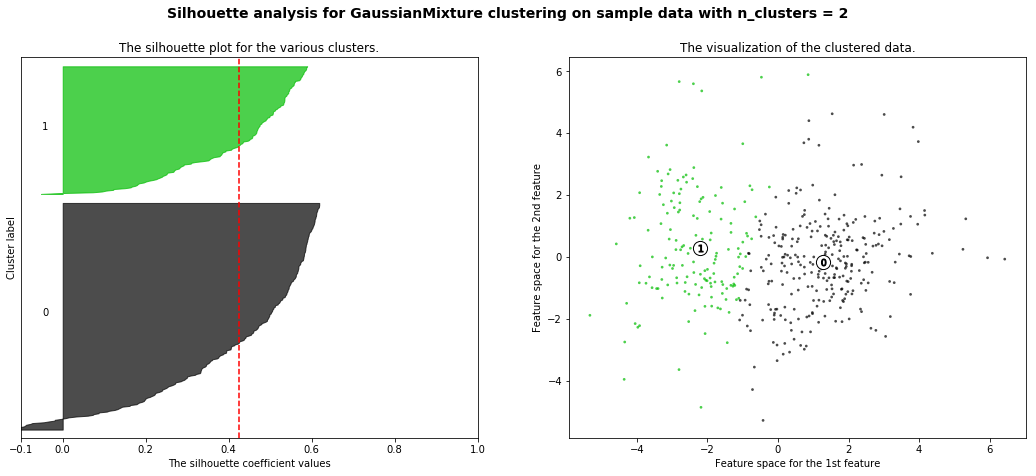

For n_clusters = 3 The average silhouette_score is : 0.371491304889


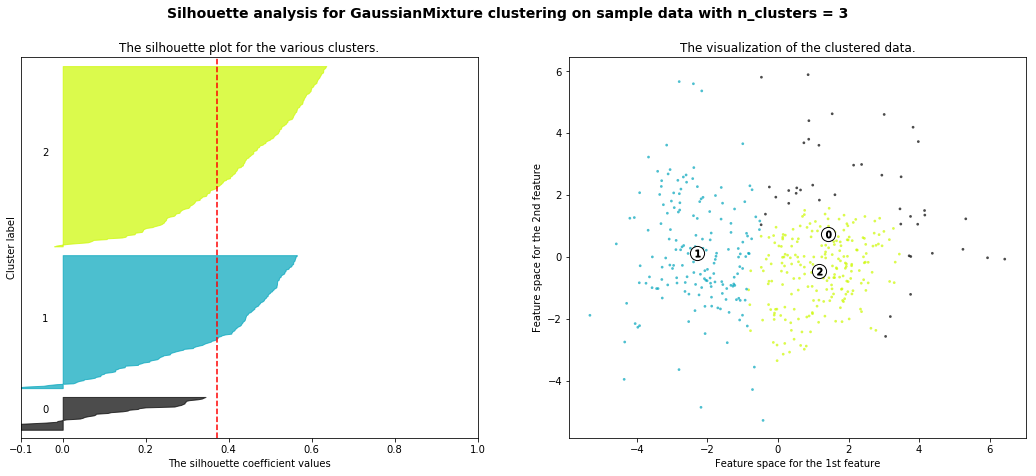

For n_clusters = 4 The average silhouette_score is : 0.306987434202


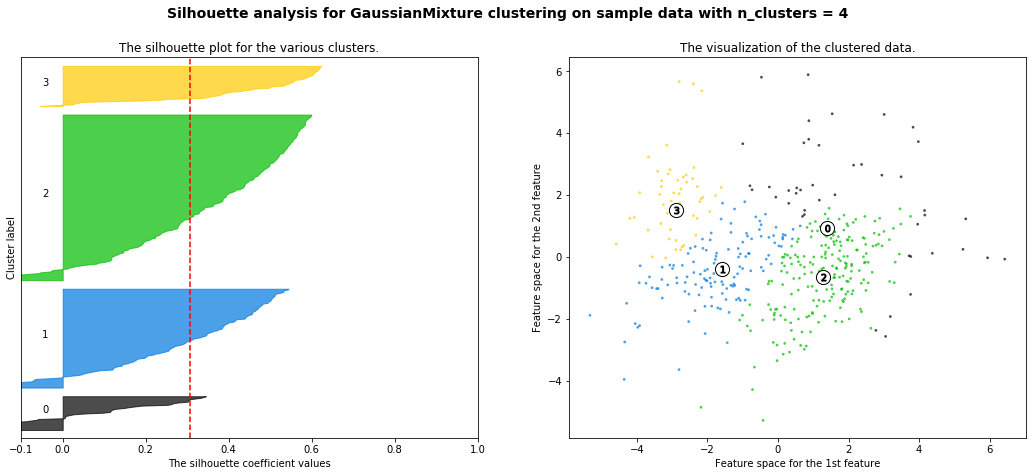

For n_clusters = 5 The average silhouette_score is : 0.213297883697


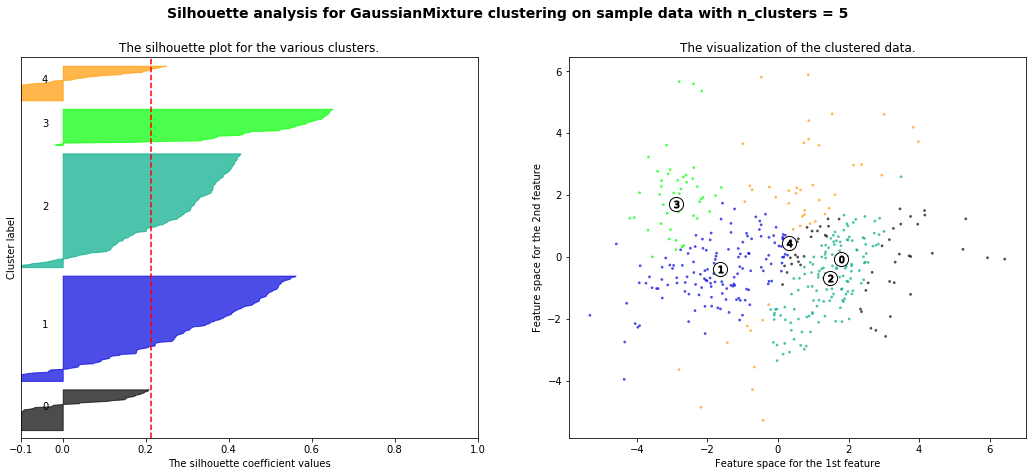

For n_clusters = 6 The average silhouette_score is : 0.282800189096


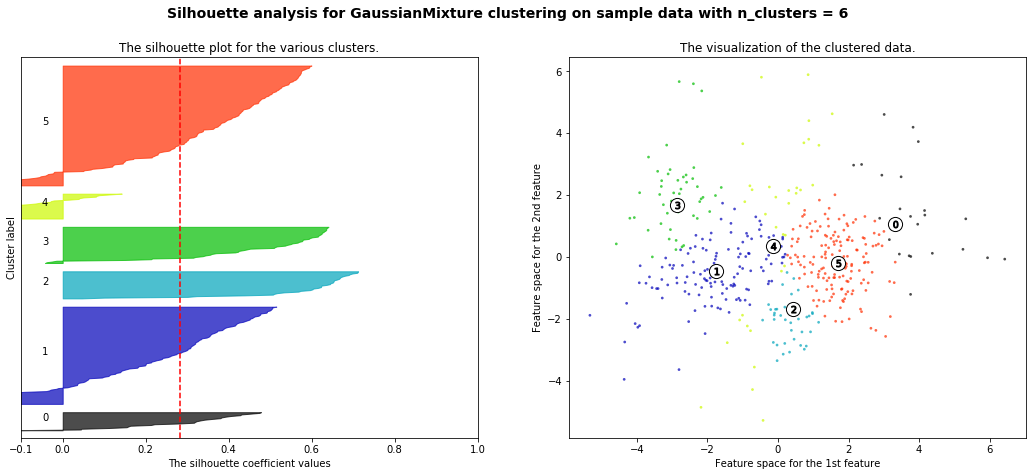

In [35]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

#Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

X = reduced_data
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10)
    clusterer.fit(X)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X['Dimension 1'], X['Dimension 2'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for GaussianMixture clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()



* The best silhouette score was seen for 2 clusters

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# TODO: Apply your clustering algorithm of choice to the reduced data

clusterer = GaussianMixture(n_components=2, random_state=0).fit(reduced_data)
# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)
# TODO: Find the cluster centers
centers = clusterer.means_
# TODO: Predict the cluster for each transformed sample data point

sample_preds = clusterer.predict(pca_samples)
# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, clusterer.predict(reduced_data))

print("silhouette score: {}".format(score))

silhouette score: 0.4229228506086596


In [37]:
centers

array([[ 1.26190644, -0.16990155],
       [-2.21903792,  0.29876856]])

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.


In [38]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8937.0,2100.0,2747.0,2076.0,353.0,731.0
Segment 1,3604.0,7878.0,12261.0,878.0,4695.0,976.0



<br>**Segment 0**: High Milk, Grocery and Detergents_Paper usage - this could be a coffee shop, bakery type of segment. Lots of milk and say bread (some varient) and dirty plates
<br>**Segemnt 1**: Below mean values of all varients and in proportions - This could be a small eatry or a food truck segment.
<br>comparing individual points to mean of the segment in this case would mean, comparing them to the cluster centers and terefore give a sense of how far/close a point is from the cluster center.

In [39]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0



<br>Sample point 0 (originally predicted to be a retailer) is found to be in Cluster 1
<br>Sample point 1 (originally predicted to be a bakery)  is found to be in Cluster 1
<br>Sample point 2 (originally predicted to be a samll eatery) found to be in Cluster 0
<br>These are consistant with our initial hunches

## Validation

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

In [49]:
data_test = data_test.drop(data_test.index[outlier_out]).reset_index(drop = True)

In [52]:
len(preds)

435

In [50]:
len(data_test.Channel)

435

In [56]:
data_test.Channel = data_test.Channel-1

In [68]:
from sklearn.metrics import accuracy_score
#preds
GaussianMM_accuracy = accuracy_score(np.array(preds), np.array(data_test.Channel))
print("Accuracy using Gaussian Mixture Modles is {}".format(GaussianMM_accuracy))

Accuracy using Gaussian Mixture Modles is 0.903448275862069


# KMeans Clustering

In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# TODO: Apply your clustering algorithm of choice to the reduced data

clustererKM = KMeans(n_clusters=2, random_state=0).fit(reduced_data)
# TODO: Predict the cluster for each data point
predsKM = clustererKM.predict(reduced_data)
# TODO: Find the cluster centers
centersKM = clustererKM.cluster_centers_
# TODO: Predict the cluster for each transformed sample data point


scoreKM = silhouette_score(reduced_data, clustererKM.predict(reduced_data))

print("silhouette score: {}".format(scoreKM))

silhouette score: 0.426877212362622


In [69]:
from sklearn.metrics import accuracy_score
#preds
Kmean_accuracy = accuracy_score(np.array(predsKM), np.array(data_test.Channel))
print("Accuracy using KMeans is {}".format(Kmean_accuracy))

Accuracy using KMeans is 0.8896551724137931


# Accuracy comparison

* Gaussian Mixture Model - 90.34%
* K-Means algorithm - 88.96%

### Gaussian Minture Models is the better algorithm for the given data. As we saw the scaled data represents Gaussian distribution and that explains the better performance of Gaussian Mixture Model


Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 




<br>This change can affect differnet customers differently. Moving to a 3 days a week delivery from a five days a week means the need/ cost for increased storage space.<br>
Assuming that customers can/ are willing to find staorage space since the chaage is not that drastic, Fresh and Milk items might not stay the same in refridgerators. That'd mean that segment 0 in our clusters might react more negitively than segment 1. <br>
Segment 1 has a higher amount of frozen items and Delicatessen which stay relatively good. Thereofre segment 1 might react positively and segment 0 might react negitively.

To implement the A/B tests, the distrubutor can collect feedback for the different segments and compare the results to the feedback original delivery systems. By comparing the performance statistics before (A) and after (B) specific to the segments, we can determine which one perform better or worse.